In [1]:
#pip3 install google.colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

###  Libraries

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

import torch

import os
import sys

from Autoencoder import Autoencoder, CD_Autoencoder
from Datasets_Functions import *
from Visualization import Visualization
from Evaluations.Evaluation import Evaluator
from General_Functions import General_Functions

/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Global Variables

In [3]:
path_to_module = './' # 'C:\\Users\\PAPASOFT INC\\Desktop\\SOFT_SIL'
sys.path.append(path_to_module)
os.environ['OMP_NUM_THREADS'] = '6'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

### Visualization

In [4]:
visualization = Visualization()

### ***LOAD DATASET***

In [5]:
hashmap = get_hashmap(path_to_module)
print(hashmap.keys())
dataset_name = 'R3'
dataset_properties = hashmap[dataset_name]
print(dataset_properties)
batch_size = dataset_properties['batch_size'] = 100
n_clusters = dataset_properties['n_clusters'] #= 3
dataloader, input_dim, data_np, labels = function_get_dataset(dataset_properties)
print('Data_Shape is:', input_dim)
print('Batches Number is:', len(dataloader))

dict_keys(['10x73k', 'TCGA', 'coil20', 'eMNIST_balanced_letters', 'eMNIST_mnist', 'eMNIST_balanced_digits', 'Dermatology', 'Ecoil', 'Iris', 'Rings', 'Wine', 'Australian', 'Moons', 'Squeezed_Gauss', 'Gauss_Densities', 'Pendigits', 'fashionMNIST', '3DSpheres', '20_NewsGroups', 'COIL20', 'CIFAR10', 'STL10', 'R15', 'R3'])
{'batch_size': 100, 'n_clusters': 3, 'module_name': 'Datasets.Datasets', 'function_name': 'load_R3_dataloader', 'option_name': ''}
Data_Shape is: 2
Batches Number is: 15


### Parameters

In [6]:
# Latent Dimension, Number of Channels and Negative Slope
latent_dim = 2
n_channels = 1
n_clusters = dataset_properties['n_clusters']

# Batch Size and Number of Clusters
batch_size = dataset_properties['batch_size']
negative_slope = 0

# Pre-Training Epochs and Learning Rate
n_pret_epochs = 100
pret_lr = 1e-3

# Lamdas, Training Epochs and Learning Rate
n_epochs = 1
lr = 1e-4
sil_lambda = 0.01
entr_lambda = 0.01

kmeans_initialization = True
pretrain = True
is_MLP_AE = True

### Create Autoencoder Model

In [7]:
if is_MLP_AE:
    autoencoder = Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()
else:
    autoencoder = CD_Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope, n_channels=n_channels)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()
autoencoder = autoencoder.to(device)

In [8]:
autoencoder

Autoencoder(
  (encoder_model): Sequential(
    (0): Linear(in_features=2, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0, inplace=True)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): LeakyReLU(negative_slope=0, inplace=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=500, out_features=2000, bias=True)
    (7): LeakyReLU(negative_slope=0, inplace=True)
    (8): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=2000, out_features=2, bias=True)
    (10): Tanh()
    (11): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cluster_model): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=False)
  )
  (decoder_model): Sequential(
    (0): Linear(in_features=2, out_features=2000, b

### Pretrain Autoencoder Model

In [9]:
if(pretrain):
    autoencoder.pretrain_autoencoder()
    # autoencoder.save_pretrained_weights()
else:
    # TODO Giannis
    model_save_path = autoencoder.dataDirPath + "\\Weigths\\autoencoder_weights.pth"
    autoencoder.load_state_dict(torch.load(model_save_path))
    normPreTrEpochs = autoencoder.preTrEpochs  
    autoencoder.preTrEpochs = 1
    autoencoder.pretrain_autoencoder()
    autoencoder.preTrRpochs = normPreTrEpochs

Epoch: 0, Loss: 4.317832
Epoch: 1, Loss: 1.126249
Epoch: 2, Loss: 1.041177
Epoch: 3, Loss: 1.163893
Epoch: 4, Loss: 0.997444
Epoch: 5, Loss: 0.801800
Epoch: 6, Loss: 0.715983
Epoch: 7, Loss: 0.734968
Epoch: 8, Loss: 0.632781
Epoch: 9, Loss: 0.659721
Epoch: 10, Loss: 0.583742
Epoch: 11, Loss: 0.626281
Epoch: 12, Loss: 0.675783
Epoch: 13, Loss: 0.526735
Epoch: 14, Loss: 0.541881
Epoch: 15, Loss: 0.555921
Epoch: 16, Loss: 0.527080
Epoch: 17, Loss: 0.547389
Epoch: 18, Loss: 0.530615
Epoch: 19, Loss: 0.479138
Epoch: 20, Loss: 0.467319
Epoch: 21, Loss: 0.445369
Epoch: 22, Loss: 0.423203
Epoch: 23, Loss: 0.415197
Epoch: 24, Loss: 0.358222
Epoch: 25, Loss: 0.382566
Epoch: 26, Loss: 0.383272
Epoch: 27, Loss: 0.354931
Epoch: 28, Loss: 0.347203
Epoch: 29, Loss: 0.340459
Epoch: 30, Loss: 0.265718
Epoch: 31, Loss: 0.261812
Epoch: 32, Loss: 0.239075
Epoch: 33, Loss: 0.231777
Epoch: 34, Loss: 0.319512
Epoch: 35, Loss: 0.306916
Epoch: 36, Loss: 0.243245
Epoch: 37, Loss: 0.264849
Epoch: 38, Loss: 0.267

In [10]:
# Initialize the clustering layer using k-means
if kmeans_initialization: autoencoder.kmeans_initialization(100)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb2bf7a6320>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb1b17b79a0>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb1b17b79a0>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb1b17b79a0>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb1b17b79a0>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb1b17b7370>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb1b17b7370>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb1b17b7370>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb1b17b7370>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb2bf7a6320>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb2bf7a6320>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb2bf7a6320>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


ACC: 0.99 PUR: 0.99 NMI: 0.94 ARI: 0.96


In [11]:
"""
while True:
    # Code block to execute repeatedly
    autoencoder.trEpochs = 10
    autoencoder.train_autoencoder(silhouette_method = "default")
    visualization.makeExcel()
    #visualization.makePlot(useTSNE=False)
    #visualization.makePlot(useTSNE=True)
    visualization.plot_3D()

    # Check the condition to exit the loop
    if autoencoder.experimentName == "Experiment_400":
        break
"""
autoencoder.set_training_variables(n_epochs=10, lr=lr, sil_lambda=0.01, entr_lambda=0.00)

latent_data, labels, clustering = autoencoder.train_autoencoder()

cluster_centers = autoencoder.get_cluster_centers().cpu().detach().numpy()

Ep: 0 Rec L: 0.1664 Cl L: 0.0793 Entropy: 0.0000 SSil: 7.0715 SIL: 0.0000 ACC: 0.98 PUR: 0.98 NMI: 0.93 ARI: 0.94
Ep: 1 Rec L: 0.1589 Cl L: 0.0807 Entropy: 0.0000 SSil: 6.9286 SIL: 0.0000 ACC: 0.97 PUR: 0.97 NMI: 0.90 ARI: 0.90
Ep: 2 Rec L: 0.1501 Cl L: 0.0789 Entropy: 0.0000 SSil: 7.1147 SIL: 0.0000 ACC: 0.98 PUR: 0.98 NMI: 0.94 ARI: 0.95
Ep: 3 Rec L: 0.1444 Cl L: 0.0775 Entropy: 0.0000 SSil: 7.2473 SIL: 0.0000 ACC: 0.99 PUR: 0.99 NMI: 0.97 ARI: 0.98
Ep: 4 Rec L: 0.1439 Cl L: 0.0781 Entropy: 0.0000 SSil: 7.1888 SIL: 0.0000 ACC: 0.99 PUR: 0.99 NMI: 0.94 ARI: 0.96
Ep: 5 Rec L: 0.1443 Cl L: 0.0780 Entropy: 0.0000 SSil: 7.2014 SIL: 0.0000 ACC: 0.98 PUR: 0.98 NMI: 0.93 ARI: 0.94
Ep: 6 Rec L: 0.1404 Cl L: 0.0771 Entropy: 0.0000 SSil: 7.2894 SIL: 0.0000 ACC: 0.98 PUR: 0.98 NMI: 0.94 ARI: 0.96
Ep: 7 Rec L: 0.1432 Cl L: 0.0762 Entropy: 0.0000 SSil: 7.3801 SIL: 0.0000 ACC: 0.99 PUR: 0.99 NMI: 0.98 ARI: 0.98
Ep: 8 Rec L: 0.1480 Cl L: 0.0759 Entropy: 0.0000 SSil: 7.4101 SIL: 0.0000 ACC: 0.99 PUR:

/home/geo/Desktop/Soft-Silhouette/Visualization.py:67: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(cluster_centers[:n_clusters, 0], cluster_centers[:n_clusters, 1], c='red', marker='x', s=500, edgecolors='black', label='Cluster Centers')


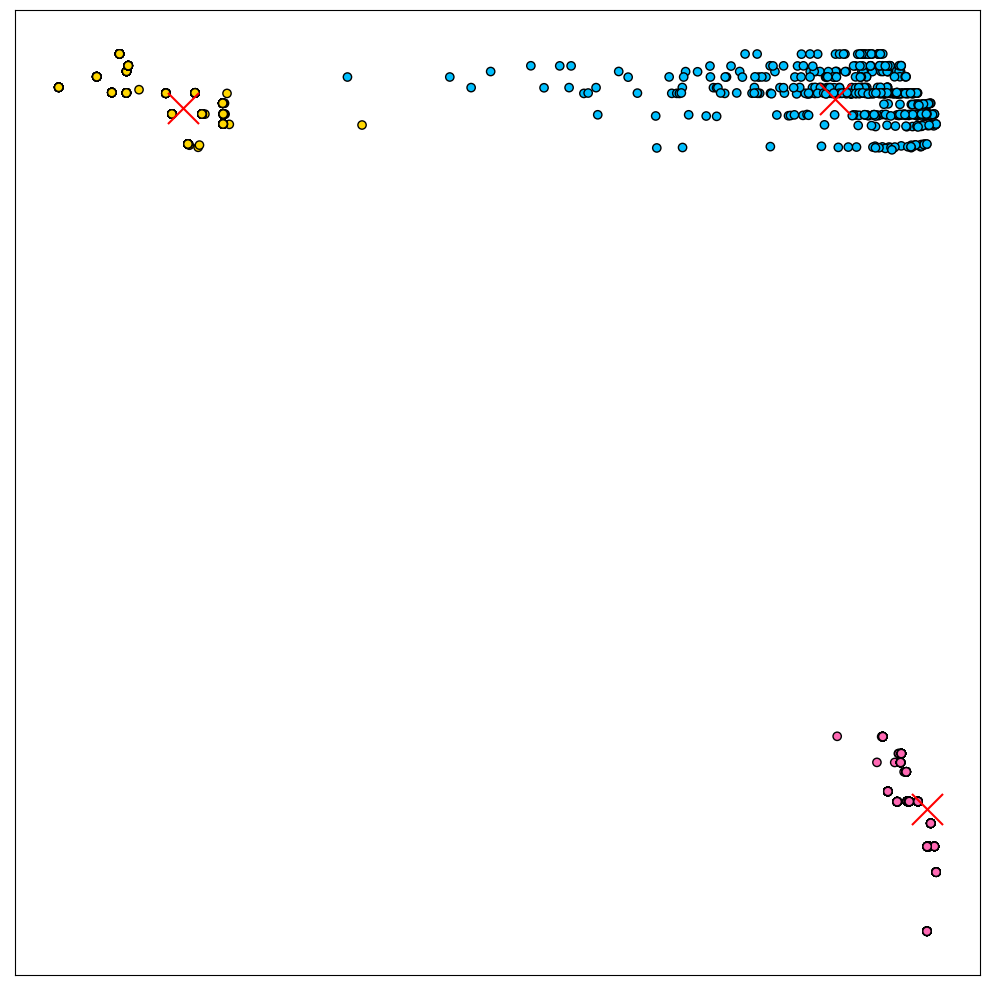

In [12]:
visualization.plot(latent_data, labels, clustering, cluster_centers)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1503 samples in 0.001s...
[t-SNE] Computed neighbors for 1503 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1503


/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1503 / 1503
[t-SNE] Mean sigma: 0.000010
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.541920
[t-SNE] KL divergence after 300 iterations: 0.321945


/home/geo/Desktop/Soft-Silhouette/Visualization.py:41: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(tsne_embeddings[:n_clusters, 0], tsne_embeddings[:n_clusters, 1], c='red', marker='x', s=500, edgecolors='black', label='Cluster Centers')


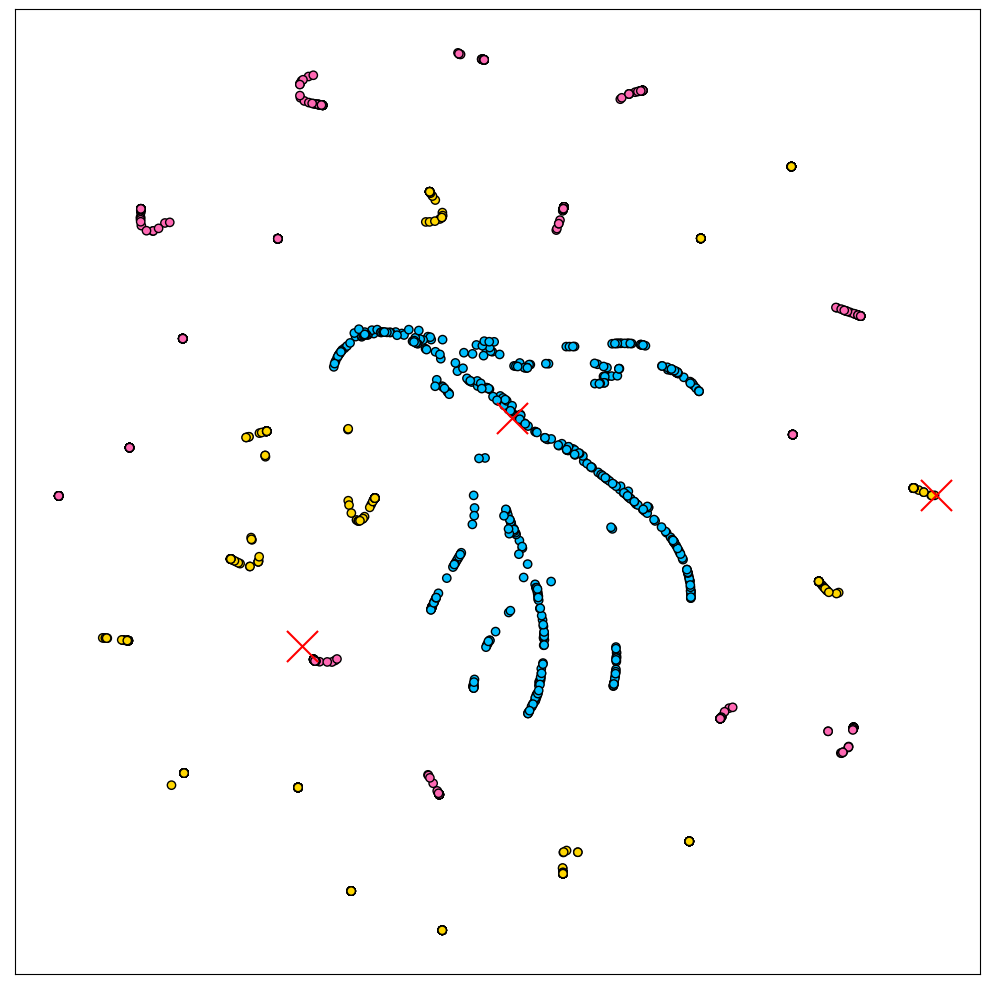

In [13]:
visualization.plot_tsne(latent_data, labels, clustering, cluster_centers)

In [14]:
# General_Functions().make_excel(autoencoder.data_dir_path, autoencoder.df_eval)

In [15]:
cluster_centers

array([[ 0.5603487 ,  0.71606374],
       [ 0.82518476, -1.4071672 ],
       [-1.326825  ,  0.6867786 ]], dtype=float32)

In [16]:
clustering[0:100]

array([2, 2, 0, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2,
       2, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 0, 1, 0, 2, 0,
       1, 2, 1, 1, 1, 2, 2, 2, 0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1,
       2, 0, 2, 2, 0, 1, 0, 1, 1, 0, 0, 0, 2, 2, 2, 0, 1, 2, 0, 1, 2, 0,
       2, 2, 2, 1, 1, 1, 2, 0, 1, 0, 2, 0])

In [17]:
latent_data

array([[-1.3770736 ,  0.7323147 ],
       [-1.3770735 ,  0.7323147 ],
       [ 0.76781917,  0.73229665],
       ...,
       [ 0.7388471 , -1.3862412 ],
       [ 0.67729956,  0.73300606],
       [ 0.7388509 , -1.3862412 ]], dtype=float32)

In [18]:
KMeans(n_clusters=3, init=cluster_centers).fit_predict(latent_data)[500:] == clustering[500:]

/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1305: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb1b16045e0>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,